# Imports and Definitions

In [1]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.9 MB/s eta 0:00:00


In [2]:
! pip install natsort

In [3]:
import einops


import random
import imageio
import numpy as np
from argparse import ArgumentParser


from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda, Resize
from torchvision.datasets import CIFAR10

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

#### celeba

In [4]:
import os
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import re
import numpy as np
import torch
import pandas as pd
from torchvision.io import read_image

img_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'
attributes_file = '/kaggle/input/celeba-dataset/list_attr_celeba.csv'
partition_file = '/kaggle/input/celeba-dataset/list_eval_partition.csv'

attr_df = pd.read_csv(attributes_file)
partition_df = pd.read_csv(partition_file)

merged_df = pd.merge(attr_df[['image_id', 'Male']], partition_df, on="image_id")
train_df = merged_df[merged_df['partition'] == 0]

image_label_mapping = {os.path.join(img_dir, row['image_id']): 1 if row['Male'] > 0 else 0 for _, row in train_df.iterrows()}

## Create a custom Dataset class
class CelebADataset(Dataset):
    def __init__(self, image_label_mapping, transform=None):
        """
        Args:
            image_label_mapping (dict): A dictionary mapping image paths to labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_label_mapping = image_label_mapping
        self.transform = transform
        self.image_paths = list(image_label_mapping.keys())

    def __len__(self):
        return len(self.image_label_mapping)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.image_label_mapping[image_path]
        
        if self.transform:
            image = self.transform(image)
            
        return image

# Визуализация данных

In [5]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().permute(0,2,3,1).numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow((255*(images[idx]+1)/2).astype('uint8'))
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [6]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch, "Первый батч")
        break


# Загрузка данных

In [9]:
from torch.utils.data import Dataset

class CifarImagesDataset(Dataset):
    def __init__(self, root='./data', train=True, transform=None, download=True):
        self.dataset = CIFAR10(root=root, train=train, transform=transform, download=download)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x

In [10]:
def my_norm(x):
    return x * 2 - 1

def my_denormalize(x):
    return torch.clamp((x + 1) / 2, min=0, max=1)

batch_size = 128
image_size = 32

transform =  Compose([
    Resize((32, 32)),
    ToTensor(),
    Lambda(my_norm),
    ])

use_cifar=False
if use_cifar:
    loader = torch.utils.data.DataLoader(
          CifarImagesDataset(root='./data', train=True, transform=transform, download=True),
          batch_size=batch_size, shuffle=True,
          num_workers=4, pin_memory=True)
else:
    image_paths = list(image_label_mapping.keys())
    labels = list(image_label_mapping.values())
    mapping = dict(zip(image_paths, labels))
    dataset = CelebADataset(mapping, transform=transform)
    loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4)

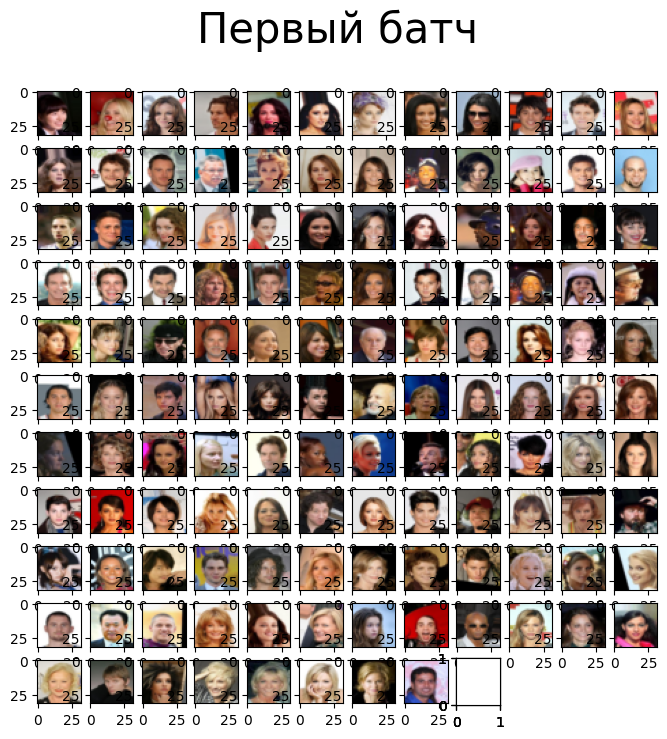

In [14]:
#show_first_batch(loader)

In [11]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	Tesla P100-PCIE-16GB


# Denoising Diffusion Model (DDPM)



In [12]:
# DDPM class
class DDPM(nn.Module):
    def __init__(self, network, # Unet
                 n_steps=1000, # YOUR CODE HERE (число шагов диффузии)
                 min_beta=1e-4, # YOUR CODE HERE
                 max_beta=1e-2, # YOUR CODE HERE
                 device=None,
                 image_chw=(3, image_size, image_size)):
        super().__init__()
        self.n_T = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device) # Ваш backbone (Unet), реализуете его ниже
        self.betas = torch.linspace(min_beta, max_beta, self.n_T).to(device) # Задайте beta по любой понравившейся сетке, как на семинаре
        self.alphas = (1 - self.betas)
        self.alpha_bars = (1 - self.betas).cumprod(axis=0)

    def forward(self, x0, t, eta=None):
        # Прямой проход диффузии (детерменированный марковский процесс)
        # :param x0 - исходная картинка (тензор формы [B,C,H,W])
        # :param t - шаг зашумления (тензор формы [B,1])
        # :param eta - \epsilon_t - добавочный шум на шаге зашумления t (тензор формы [B,C,H,W])

        if eta is None:
            eta = torch.randn_like(x0) # если шум не определен - инициализируйте его гауссом N(0,1) сами
        alpha_t = self.alpha_bars[t][:, None, None, None]
        noised_x = x0 * (alpha_t ** 0.5) + eta * (1 - alpha_t) ** 0.5
        return noised_x

    def backward(self, x, t, guide_w=None):
        # Обратный процесс. Здесь вам предстоит восстановить добавочный шум eta из зашумлённой картинки x на шаге t нейросетью
        eta_pred = self.network(x, t)
        return eta_pred

    def sample(self, n_samples, size, x=None):
        # Starting from random noise
        c, h, w = size
        if x is None:
            x = torch.randn([n_samples, c, h, w]).to(self.device) # Начинаем генерить картинки с гауссовского шума N(0,1) ([n_samples, c, h, w])

        for idx, t in enumerate(range(self.n_T-1, -1, -1)): # Денойзим наши картинки для каждого шага, начиная с последнего
            # Estimating noise to be removed
            time_tensor =  torch.tensor([t]*n_samples).reshape(-1, 1).long().to(device)  # [n_samples, 1].long()
            eta_theta = self.backward(x, time_tensor.reshape(-1)) #  Предсказываем добавочный шум нейросетью

            alpha_t = self.alphas[time_tensor][:, :, None, None]
            alpha_t_bar = self.alpha_bars[time_tensor][:, :, None, None]
            beta_t = self.betas[time_tensor][:, :, None, None]
            alpha_t_m1_bar = self.alpha_bars[time_tensor-1][:, :, None, None]

            x = (x - (1 - alpha_t) / (1 - alpha_t_bar)**0.5 * eta_theta) / (alpha_t**0.5)  # Вычитаем добавочный шум из картинки
            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)
                sigma_t = ((1-alpha_t_m1_bar) / (1-alpha_t_bar) * beta_t)**0.5 # определите сигму по любому из предлагаемых DDPM способов
                x = x + sigma_t * z
        return x

    def backward_dif(self, noise):
        n_sample = noise.shape[0]
        size = noise.shape[1:]
        device = noise.device
        x_i = self.sample(n_sample, size, x=noise)
        return x_i

    def compute_x0(self, x_t, timestep, guide_w=None):
        # computes x0 from x_t
        eps = self.backward(x_t, timestep)
        alpha_t = self.alpha_bars[timestep][:, None, None, None]
        x0 = (x_t - (1 - alpha_t) ** 0.5 * eps) / (alpha_t ** 0.5)
        return x0


# Visualizing forward and backward

In [13]:
def show_forward(ddpm, loader, device):
    for batch in loader:
        imgs = batch

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]: # Шаг зашумления (в процентах от максимального)
            noised_images = ddpm.forward(imgs, t=torch.tensor([max(0, int(ddpm.n_T * percent)-1)] * imgs.shape[0]))
            # YOUR CODE HERE. Зашумите ваши картинки прямым проходом DDPM
            show_images(
                noised_images,
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [14]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100,
                        gif_name="sampling.gif", c=3, h=image_size, w=image_size):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_T, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn([n_samples, c, h, w]).to(device) # Начинаем генерить картинки с гауссовского шума N(0,1) ([n_samples, c, h, w])
        noise = x

        for idx, t in enumerate(range(ddpm.n_T-1, -1, -1)): # Денойзим наши картинки для каждого шага, начиная с последнего
            # Estimating noise to be removed
            time_tensor =  torch.tensor([t]*n_samples).reshape(-1, 1).long().to(device)  # [n_samples, 1].long()
            eta_theta = ddpm.backward(x, time_tensor.reshape(-1)) #  Предсказываем добавочный шум нейросетью

            alpha_t = ddpm.alphas.to(device)[time_tensor][:, :, None, None]
            alpha_t_bar = ddpm.alpha_bars.to(device)[time_tensor][:, :, None, None]
            beta_t = ddpm.betas.to(device)[time_tensor][:, :, None, None]
            alpha_t_m1_bar = ddpm.alpha_bars.to(device)[time_tensor-1][:, :, None, None]

            # Partially denoising the image
            x = (x - (1 - alpha_t) / (1 - alpha_t_bar)**0.5 * eta_theta) / (alpha_t**0.5)  # Вычитаем добавочный шум из картинки
            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)
                sigma_t = ((1-alpha_t_m1_bar) / (1-alpha_t_bar) * beta_t)**0.5#beta_t ** 0.5 # определите сигму по любому из предлагаемых DDPM способов
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                normalized = x.clone()
                normalized = (torch.clip(x, -1, 1) + 1) * 255 / 2 #my_denormalize(x) # YOUR CODE HERE (нормируем картинку обратно в интервал [0,255])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return noise, torch.clip(x, -1, 1)

# UNet backbone ($\epsilon^\theta$)

In [15]:
def sinusoidal_embedding(n, d):
    # n - размерность исходных данных (в нашем случае число моментов времени)
    # d - выходная размерность
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)]) # коэффициенты для d гармоник
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1)).float()
    emb = t @ wk
    embedding = torch.cat((torch.sin(emb[:, :d//2]), torch.cos(emb[:, d//2:])), dim=1) # заполните половину из d компонент синунами sin(wk*t), оставшуюся косинусами cos(wk*t), где wk - коэффициенты гармоник
    return embedding

class ResBlock(nn.Module):
    def __init__(self, cin, cout, time_ch, n_gr=8, drop=0.1):
        super().__init__()
        self.norm1 = nn.GroupNorm(n_gr, cin)
        self.act1 = nn.Sigmoid()
        self.conv1 = nn.Conv2d(cin, cout, kernel_size=(3, 3), padding=(1, 1))
        self.time_fc = nn.Linear(time_ch, cin)
        self.time_act = nn.Sigmoid()
        self.c = [cin, cout, time_ch]

    def forward(self, x, time):
        y = self.time_fc(time * self.time_act(time))[:, :, None, None]
        x += y
        out = self.norm1(x)
        out = self.conv1(out * self.act1(out))
        return out

class Attention(nn.Module):
    def __init__(self, cin, heads=1, d = None, n_gr=8):
        super().__init__()
        if d is None:
            d = cin
        self.norm = nn.GroupNorm(n_gr, cin)
        self.fc = nn.Linear(cin, heads * d * 3)
        self.last_fc = nn.Linear(heads * d, cin)
        self.scale = d ** -0.5
        self.heads = heads
        self.d = d

    def forward(self, x, t=None):
        bs, cin, h, w = x.shape
        x = x.reshape(bs, cin, -1).permute(0, 2, 1)
        qkv = self.fc(x).reshape(bs, -1, self.heads, 3 * self.d)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        attn = attn.softmax(dim=2)
        out = torch.einsum('bijh,bjhd->bihd', attn, v).reshape(bs, -1, self.heads * self.d)
        out = self.last_fc(out) + x
        out = out.permute(0, 2, 1).reshape(bs, cin, h, w)
        return out

class UpBlock(nn.Module):
    def __init__(self, cin, cout, time_ch, has_attn):
        super().__init__()
        self.res_blk = ResBlock(cin+cout, cout, time_ch)
        if has_attn:
            self.attn = Attention(cout)
        else:
            self.attn = nn.Identity()

    def forward(self, x, t):
         return self.attn(self.res_blk(x, t))

class Middle(nn.Module):
    def __init__(self, cout, ch):
        super().__init__()
        self.res1 = ResBlock(cout, cout, ch)
        self.attn = Attention(cout)
        self.res2 = ResBlock(cout, cout, ch)

    def forward(self, x, t):
        x = self.res1(x, t)
        x = self.attn(x, t)
        x = self.res2(x, t)
        return x

class DownBlock(nn.Module):
    def __init__(self, cin, cout, time_ch, has_attn):
        super().__init__()
        self.res = ResBlock(cin, cout, time_ch)
        if has_attn:
            self.attn = Attention(cout)
        else:
            self.attn = nn.Identity()
    def forward(self, x, t):
        x = self.res(x, t)
        x = self.attn(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=16):
        super().__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim * 4)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim * 4)
        self.time_embed.requires_grad_(False) # мы эмбединг слой уже инициализировали и менять его не будем
        # First half
        #self.te1 = self._make_te(time_emb_dim, time_emb_dim * 4)

        cout, cin, ch = [time_emb_dim]*3
        B = 1
        res = [1, 2, 2]
        has_attn = [False, False, True, True]
        self.conv1 = nn.Conv2d(3, ch, kernel_size=(3, 3), padding=(1, 1))
        down = []
        for i in range(len(res)):
            cout = cin * res[i]
            for _ in range(B):
                down.append(DownBlock(cin,cout, ch * 4, has_attn[i]))
                cin = cout
            if i < len(res) - 1:
                down.append(nn.Conv2d(cin, cin, (3, 3), (2, 2), (1, 1)))
        self.down = nn.ModuleList(down)
        self.middle = Middle(cout, ch*4)
        up = []
        cin = cout
        for i in range(len(res)-1, -1, -1):
            cout = cin
            for _ in range(B):
                up.append(UpBlock(cin, cout, ch * 4, has_attn[i]))
            cout = cin // res[i]
            up.append(UpBlock(cin, cout, ch * 4, has_attn[i]))
            cin = cout
            if i > 0:
                up.append(nn.ConvTranspose2d(cin, cin, (4, 4), (2, 2), (1, 1)))
        self.up = nn.ModuleList(up)
        self.norm = nn.GroupNorm(8, ch)
        self.act = nn.Sigmoid()
        self.last = nn.Conv2d(cin, 3, kernel_size=(3, 3), padding=(1, 1))


    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

    def forward(self, x, time):
        t = self.time_embed(time)
        x = self.conv1(x)
        lst = [x]
        for layer in self.down:
            if isinstance(layer, nn.Conv2d):
                x = layer(x)
            else:
                x = layer(x, t)
            lst.append(x)
        x = self.middle(x, t)
        for layer in self.up:
            if isinstance(layer, nn.ConvTranspose2d):
                x = layer(x)
            else:
                connection = lst.pop()
                x = torch.cat((x, connection), dim=1)
                x = layer(x, t)
        x = self.norm(x)
        x = self.last(x * self.act(x))
        return x

In [16]:
# Defining model
n_steps, min_beta, max_beta = 1000, 1e-4, 1e-2
ddpm = DDPM(UNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [17]:
sum([p.numel() for p in ddpm.parameters()])

426691

# Optional visualizations

In [19]:
# Optionally, load a pre-trained model that will be further trained
store_path = '/kaggle/input/celeba_ddpm/pytorch/first/1/celeba_ddpm_4.pth'
ddpm.load_state_dict(torch.load(store_path, map_location=device))

<All keys matched successfully>

In [20]:
# Optionally, show the diffusion (forward) process
#show_forward(ddpm, loader, device)

torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])


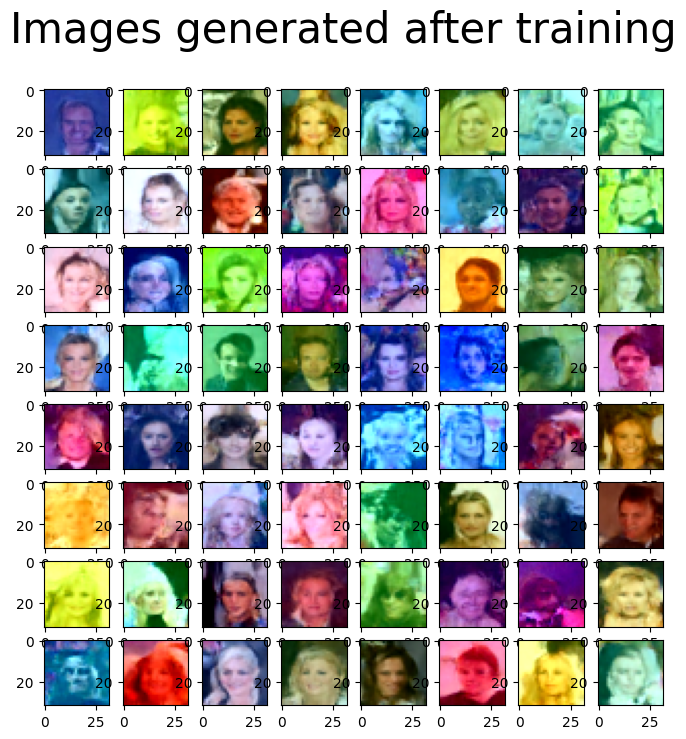

In [21]:
# Optionally, show the denoising (backward) process
noise, generated = generate_new_images(ddpm, n_samples=64, gif_name="after_training.gif", frames_per_gif=10)
print(noise.shape)
print(generated.shape)
show_images(generated, "Images generated after training")

In [22]:
import os

os.mkdir('images')
os.mkdir('noise')

In [23]:
for i in range(200):
    noise, generated = generate_new_images(ddpm, n_samples=64, gif_name="before_training.gif", frames_per_gif=10)
    torch.save(noise.detach().cpu(), '/kaggle/working/noise' + '/{}.pt'.format(i))
    torch.save(generated.detach().cpu(), '/kaggle/working/images' + '/{}.pt'.format(i))

Exception ignored in: <function _xla_gc_callback at 0x7ef5aa343640>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [29]:
! zip -r '/kaggle/working/noise_celeba.zip' '/kaggle/working/noise'

  adding: kaggle/working/noise/ (stored 0%)
  adding: kaggle/working/noise/105.pt (deflated 8%)
  adding: kaggle/working/noise/66.pt (deflated 8%)
  adding: kaggle/working/noise/18.pt (deflated 8%)
  adding: kaggle/working/noise/29.pt (deflated 8%)
  adding: kaggle/working/noise/139.pt (deflated 7%)
  adding: kaggle/working/noise/103.pt (deflated 7%)
  adding: kaggle/working/noise/75.pt (deflated 8%)
  adding: kaggle/working/noise/151.pt (deflated 8%)
  adding: kaggle/working/noise/91.pt (deflated 8%)
  adding: kaggle/working/noise/155.pt (deflated 8%)
  adding: kaggle/working/noise/106.pt (deflated 7%)
  adding: kaggle/working/noise/26.pt (deflated 8%)
  adding: kaggle/working/noise/136.pt (deflated 8%)
  adding: kaggle/working/noise/166.pt (deflated 8%)
  adding: kaggle/working/noise/3.pt (deflated 8%)
  adding: kaggle/working/noise/122.pt (deflated 8%)
  adding: kaggle/working/noise/141.pt (deflated 8%)
  adding: kaggle/working/noise/119.pt (deflated 8%)
  adding: kaggle/working/noi

In [30]:
! zip -r '/kaggle/working/images_celeba.zip' '/kaggle/working/images'

  adding: kaggle/working/images/ (stored 0%)
  adding: kaggle/working/images/105.pt (deflated 20%)
  adding: kaggle/working/images/66.pt (deflated 21%)
  adding: kaggle/working/images/18.pt (deflated 19%)
  adding: kaggle/working/images/29.pt (deflated 20%)
  adding: kaggle/working/images/139.pt (deflated 20%)
  adding: kaggle/working/images/103.pt (deflated 17%)
  adding: kaggle/working/images/75.pt (deflated 17%)
  adding: kaggle/working/images/151.pt (deflated 18%)
  adding: kaggle/working/images/91.pt (deflated 20%)
  adding: kaggle/working/images/155.pt (deflated 18%)
  adding: kaggle/working/images/106.pt (deflated 19%)
  adding: kaggle/working/images/26.pt (deflated 18%)
  adding: kaggle/working/images/136.pt (deflated 17%)
  adding: kaggle/working/images/166.pt (deflated 19%)
  adding: kaggle/working/images/3.pt (deflated 19%)
  adding: kaggle/working/images/122.pt (deflated 20%)
  adding: kaggle/working/images/141.pt (deflated 20%)
  adding: kaggle/working/images/119.pt (defla